# **A. Clustering**
### **A comparison of the clustering algorithms**
 Analisis klaster adalah teknik yang digunakan untuk mengelompokkan data ke dalam beberapa grup berdasarkan kemiripan tertentu, yang memungkinkan identifikasi pola atau struktur dalam data. Metode-metode klastering yang berbeda seperti KMeans, Spectral Clustering, Agglomerative Clustering, DBSCAN, OPTICS, Gaussian Mixture, dan lainnya masing-masing memiliki pendekatan yang unik dalam menangani variasi struktur data. Berikut adalah tabel dan visualisasi perbandingan masing-masing metode

| Method name               | Parameters                                            | Scalability                                            | Usecase                                                                 | Geometry (metric used)                              |
|---------------------------|-------------------------------------------------------|--------------------------------------------------------|------------------------------------------------------------------------|-----------------------------------------------------|
| K-Means                   | number of clusters                                    | Very large n_samples, medium n_clusters with MiniBatch code | General-purpose, even cluster size, flat geometry, not too many clusters, inductive | Distances between points                            |
| Affinity propagation      | damping, sample preference                            | Not scalable with n_samples                            | Many clusters, uneven cluster size, non-flat geometry, inductive       | Graph distance (e.g. nearest-neighbor graph)        |
| Mean-shift                | bandwidth                                             | Not scalable with n_samples                            | Many clusters, uneven cluster size, non-flat geometry, inductive       | Distances between points                            |
| Spectral clustering       | number of clusters                                    | Medium n_samples, small n_clusters                      | Few clusters, even cluster size, non-flat geometry, transductive       | Graph distance (e.g. nearest-neighbor graph)        |
| Ward hierarchical clustering | number of clusters or distance threshold            | Large n_samples and n_clusters                          | Many clusters, possibly connectivity constraints, transductive         | Distances between points                            |
| Agglomerative clustering  | number of clusters or distance threshold, linkage type, distance | Large n_samples and n_clusters                          | Many clusters, possibly connectivity constraints, non Euclidean distances, transductive | Any pairwise distance                                |
| DBSCAN                    | neighborhood size                                     | Very large n_samples, medium n_clusters                 | Non-flat geometry, uneven cluster sizes, outlier removal, transductive | Distances between nearest points                    |
| OPTICS                    | minimum cluster membership                            | Very large n_samples, large n_clusters                  | Non-flat geometry, uneven cluster sizes, variable cluster density, outlier removal, transductive | Distances between points                            |
| Gaussian mixtures         | many                                                  | Not scalable                                           | Flat geometry, good for density estimation, inductive                 | Mahalanobis distances to centers                    |
| BIRCH                     | branching factor, threshold, optional global clusterer | Large n_clusters and n_samples                          | Large dataset, outlier removal, data reduction, inductive             | Euclidean distance between points                   |
| Bisecting K-Means         | number of clusters                                    | Very large n_samples, medium n_clusters                 | General-purpose, even cluster size, flat geometry, no empty clusters, inductive, hierarchical | Distances between points                            |

Referensi: [Scikit-learn](https://scikit-learn.org/stable/modules/clustering.html)


In [1]:
import time
import warnings
from itertools import cycle, islice

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

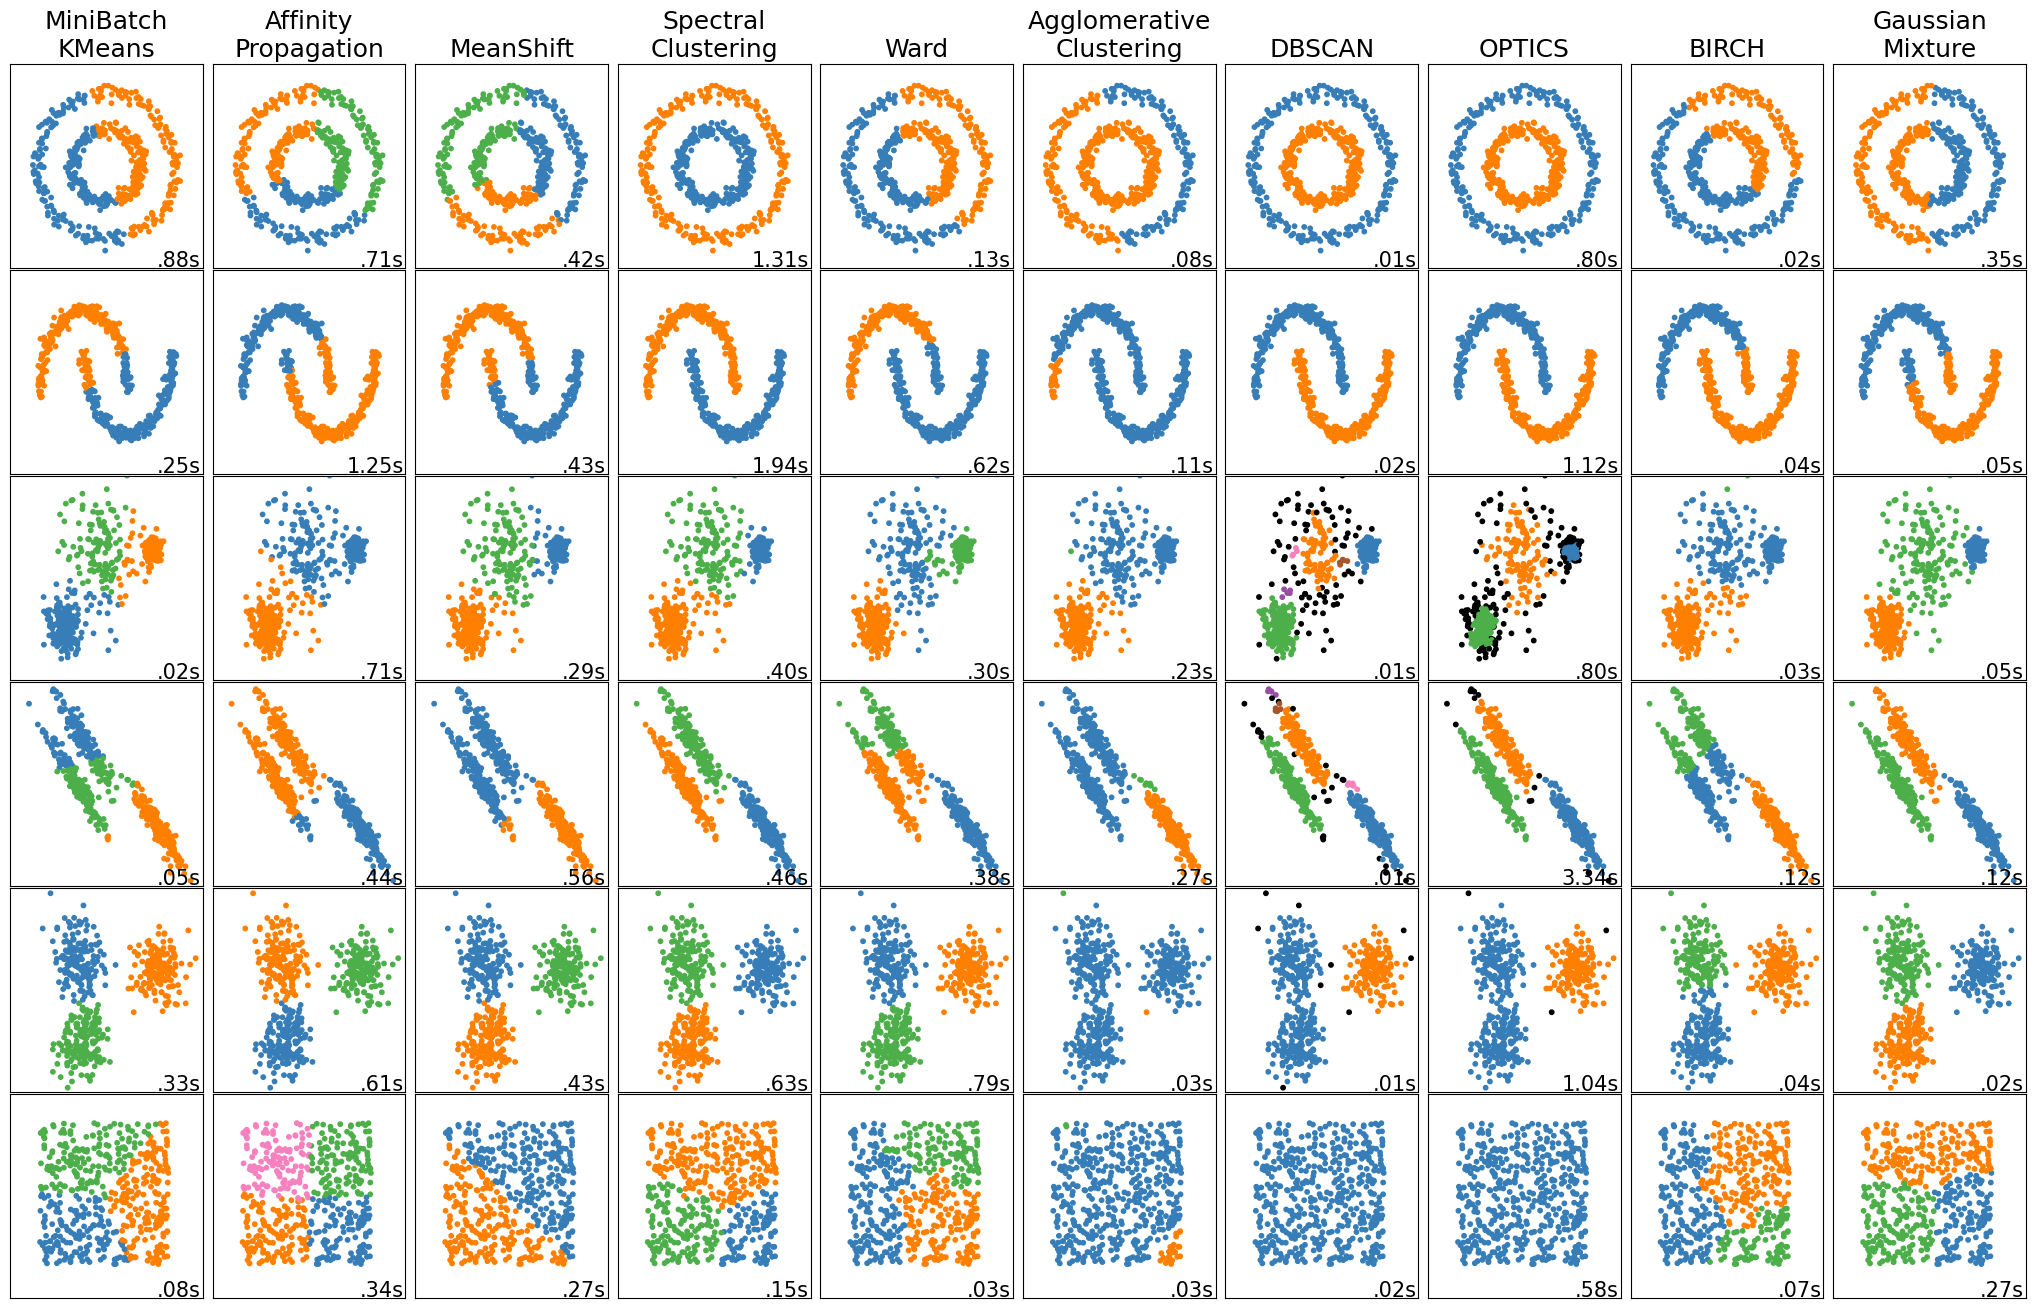

In [2]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

## Metode
Berdasarkan komparansi sebelumnya, maka terdapat beberapa pendekatan untuk melakukan analisis klaster. Yang mana setiap pendekatan paling cocok untuk distribusi data tertentu. Berikut ini akan dijelaskan beberapa pendekatan tersebut secara singkat yang sebagian disertai dengan implementasinya menggunakan python, sisanya dapat dieksplorasi oleh peserta didik secara mandiri 👌

### 1. Centroid Based Clustering
Metode ini mengelompokkan data berdasarkan jarak dari centroid (titik pusat) klaster. Algoritma berbasis centroid efisien karena mudah dipahami dan diimplementasikan, tetapi sensitif terhadap kondisi awal (initial centroid) dan outlier.<br>
**Contoh**: K-mean, K-medoids, K-median <br>
<img src="https://developers.google.com/static/machine-learning/clustering/images/CentroidBasedClustering.svg" alt="Centroid Based Clustering" width="300" height="300">


### 2. Density Based Clustering
Metode ini mengelompokkan data berdasarkan kepadatan wilayah/area-nya (density). Klaster terbentuk dari wilayah dengan kepadatan tinggi yang dipisahkan oleh wilayah dengan kepadatan rendah. Metode ini mampu menangani noise dan outlier (diabaikan), tetapi kesulitan menangani data dengan kepadatan yang sangat bervariasi<br>
**Contoh**: DBSCAN (Density-Based Spatial Clustering of Applications with Noise), OPTICS<br>
<img src="https://developers.google.com/static/machine-learning/clustering/images/DensityClustering.svg" alt="Density Based Clustering" width="300" height="300">

> #### DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) adalah algoritma clustering yang mengelompokkan titik data berdasarkan kepadatan wilayah. Algoritma ini tidak memerlukan jumlah klaster sebelumnya (initial) dan mampu mengidentifikasi klaster dengan bentuk yang kompleks serta menangani noise dengan baik. <br><br>
Langkah-langkah algoritma DBSCAN:
1. Menentukan Parameter: DBSCAN memerlukan dua parameter utama:
  * epsilon (ε): jarak maksimum antara dua titik (sampel) yang masih dianggap tetangga. Ini bukan batasan maksimum pada jarak titik-titik dalam sebuah klaster, melainkan seberapa jauh algoritma akan mencari tetangga-tetangga dari setiap titik (sampel) data untuk membentuk sebuah klaster. Parameter ini memiliki nilai default = 0.5
  * min_samples: mengatur jumlah minimum sampel dalam satu klaster. Parameter ini memiliki nilai default = 5
2. Membentuk Klaster: Algoritma memulai dengan titik acak dan mencari tetangga-tetangganya dalam jarak ε. Jika titik tersebut memiliki jumlah tetangga yang cukup (≥ min_samples), maka titik tersebut dianggap sebagai **core point** dan membentuk sebuah klaster. Titik-titik tetangga dari core point tersebut kemudian dimasukkan ke dalam klaster yang sama.
3. Memperluas Klaster: Algoritma kemudian memperluas klaster dengan menemukan tetangga dari tetangga-tetangga core point dan menambahkan mereka ke dalam klaster yang sesuai. Proses ini terus berlanjut hingga tidak ada lagi titik yang dapat ditambahkan ke dalam klaster.
4. Menandai Noise: Titik-titik yang tidak termasuk dalam klaster dan tidak memenuhi syarat sebagai core point atau titik yang terhubung dengan klaster lainnya dianggap sebagai noise.
<br><br>
Berdasarkan penjelasan di atas, maka algoritma ini tidak memerlukan penentuan jumlah klaster sebelumnya, mampu menangani klaster dengan bentuk yang kompleks, serta mampu menangani noise ataupun outlier dengan baik. Namun, algoritma ini cenderung sensitif terhadap pemilihan parameter ε dan min_samples serta performanya bisa menurun pada dataset dengan dimensi yang sangat tinggi.









In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
country_data = pd.read_csv('/content/drive/MyDrive/SEMESTER 6 WAW/Asprak Datmin/Gian Vers. -- Unsupervised Learning #2 /Country-data.csv')
display(country_data.head(), country_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


None

In [5]:
country_data1 = country_data.drop(['income', 'total_fer', 'exports'], axis = 1) # terdapat 3 pasangan variabel dengan korelasi kuat, buang 1 variabel tiap pasangan (periksa menggunakan heatmap correlation)

# Scaling
scaler = StandardScaler()
country_data1 = pd.DataFrame(scaler.fit_transform(country_data1.drop('country', axis = 1)), columns = scaler.get_feature_names_out(), index = country_data.country)
country_data1.head()

,child_mort,health,imports,inflation,life_expec,gdpp
country,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817


Tidak terdapat missing value pada data, tahapan EDA, preprocessing, dan sebagainya diserahkan pada peserta didik. Untuk pembelajaran ini akan berfokus pada masing-masing algoritma

---



In [6]:
# Pre-processing
# ...


In [7]:
# EDA
# ...


In [8]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [9]:
# Opsional: Tuning parameter eps dan min_samples
df_db = country_data1.copy()

for eps in [i/10 for i in range(7,10)]: # sesuaikan range parameter eps
    for min_samples in range(3, 8): # sesuaikan range parameter min_samples
        print(f'n_eps {eps}')
        print(f'min samples {min_samples}')

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_db)

        # Periksa apakah terdapat cluster yang terbentuk
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels) - (1 if - 1 in labels else 0)  # Jumlah klaster, mengabaikan noise
        if n_clusters > 1:  # Cek apakah terdapat lebih dari satu klaster yang terbentuk
            score = silhouette_score(df_db, labels)
            print(f'clusters present: {unique_labels}')
            print(f'clusters sizes: {np.bincount(labels + 1)}')
            print(f'Silhouette Score: {score}', '\n')
        else:
            print("Tidak ada klaster yang terbentuk dengan parameter ini.\n")


n_eps 0.7
min samples 3
clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10]
clusters sizes: [82 34 14  9  6  3  3  3  4  3  3  3]
Silhouette Score: -0.13034205235551902 

n_eps 0.7
min samples 4
clusters present: [-1  0  1  2  3  4]
clusters sizes: [109  34   6   6   8   4]
Silhouette Score: -0.0840276103143196 

n_eps 0.7
min samples 5
clusters present: [-1  0  1  2]
clusters sizes: [124  29   8   6]
Silhouette Score: -0.10901724550125563 

n_eps 0.7
min samples 6
clusters present: [-1  0  1  2]
clusters sizes: [128  27   6   6]
Silhouette Score: -0.1343349326805127 

n_eps 0.7
min samples 7
Tidak ada klaster yang terbentuk dengan parameter ini.

n_eps 0.8
min samples 3
clusters present: [-1  0  1  2  3  4]
clusters sizes: [56 90  8  7  3  3]
Silhouette Score: -0.13272291186297755 

n_eps 0.8
min samples 4
clusters present: [-1  0  1  2]
clusters sizes: [70 83  7  7]
Silhouette Score: -0.02444454644538132 

n_eps 0.8
min samples 5
clusters present: [-1  0  1  2]
clusters sizes: [7

Hyperparameter terbaik adalah eps: 0.9 dan min_samples: 3, karena memiliki Silhouette Score tertinggi (ada kemungkinan hasil berbeda tiap running)

In [10]:
# DBSCAN
dbscan = DBSCAN(eps = 0.9, min_samples = 3)
labels = dbscan.fit_predict(country_data1)
df_db['klaster'] = labels

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Persebaran klaster
df_db.klaster.value_counts() #label -1 adalah noise

Estimated number of clusters: 2
Estimated number of noise points: 50


klaster
 1    104
-1     50
 0     13
Name: count, dtype: int64

In [11]:
df_db.head()

,child_mort,health,imports,inflation,life_expec,gdpp,klaster
country,,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180,0
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623,1
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376,1
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268,-1
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817,1


63.16622716747933 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

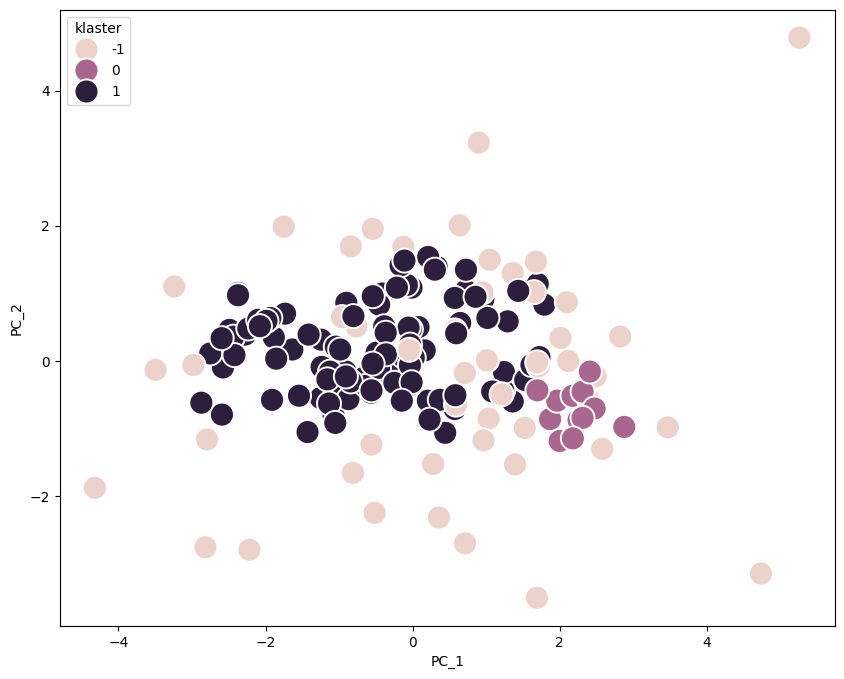

In [12]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
df_pca1 = pd.DataFrame(pca.fit_transform(df_db.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_db.index)

df_pca1 = pd.concat([df_pca1, df_db.klaster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca1, x = 'PC_1', y = 'PC_2', hue = 'klaster', s = 300, ax = ax)

In [13]:
# Gunakan metric silhouette score dan davies-bouldin index

from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette = silhouette_score(country_data1, df_db.klaster)
db_index = davies_bouldin_score(country_data1, df_db.klaster)

print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")

Silhouette Score: 0.15
Davies-Bouldin Index: 2.66


### 3. Hierarchical Clustering
Metode ini membangun hierarki klaster secara bertahap dengan melakukan penggabungan (agglomerative) atau pemisahan (divisive) titik data. Pengelompokan hierarki menciptakan pohon klaster sehingga sangat cocok untuk data hierarki, seperti taksonomi. Kelebihan dari metode ini adalah tidak memerlukan penentuan jumlah klaster sebelumnya dan memberikan informasi tentang hubungan hierarkis, teteapi kurang efisien untuk dataset besar.<br>
**Contoh**: Agglomerative Clustering, BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)<br>
<img src="https://developers.google.com/static/machine-learning/clustering/images/HierarchicalClustering.svg" alt="Hierarchical Clustering" width="300" height="300">


### 4. Distribution Based Clustering
Clustering berbasis distribusi adalah pendekatan analisis klaster yang mengasumsikan bahwa data dihasilkan dari campuran beberapa distribusi probabilitas. Metode ini mencoba untuk mengidentifikasi distribusi-distribusi ini dan menempatkan titik-titik data ke dalam klaster berdasarkan probabilitas data dihasilkan oleh distribusi tertentu. Contohnya pada gambar di bawah ini dengan pendekatan asumsi distribusi Gaussian. Pada gambar tersebut algoritma berbasis distribusi mengelompokkan data menjadi tiga distribusi Gaussian. Semakin jauh jarak dari pusat distribusi, kemungkinan suatu titik termasuk dalam distribusi semakin berkurang<br>
**Contoh**: Gaussian Mixture Models (GMM)<br>
<img src=https://developers.google.com/static/machine-learning/clustering/images/DistributionClustering.svg alt="Distribution Based Clustering" width="300" height="300">


> #### Gaussian Mixture Models
Gaussian Mixture Model (GMM) adalah model probabilistik yang digunakan untuk pengelompokan (clustering) dan estimasi kepadatan. Diasumsikan bahwa data dihasilkan dari campuran beberapa distribusi Gaussian, masing-masing mewakili klaster yang berbeda. GMM memberikan probabilitas pada titik data, memungkinkan titik tersebut menjadi bagian dari beberapa klaster secara bersamaan (soft clustering).
<br><br>
Misalkan kita memiliki tiga distribusi Gaussian, yaitu GD1, GD2, dan GD3. Ini masing-masing memiliki nilai rata-rata (μ1, μ2, μ3) dan varians (σ1, σ2, σ3) tertentu. Untuk keseluruhan titik data (sampel), GMM kami akan mengidentifikasi probabilitas setiap titik data yang termasuk dalam setiap distribusi ini.<BR>
<img src=https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/Screenshot-from-2019-10-21-12-53-29.png alt="GMM" width="400" height="400">
<br>
Pada gambar di atas, titik data yang dilingkari warna merah, memiliki peluang menjadi bagian dari klaster hijau adalah 0, serta peluang bahwa titik ini termasuk warna biru dan cyan masing-masing adalah 0.2 dan 0.8. Dalam hal ini, titik data tersebut masuk ke dalam klaster dengan peluang tertinggi, yaitu cyan.



In [14]:
df_gmm = country_data1.copy()
df_gmm

,child_mort,health,imports,inflation,life_expec,gdpp
country,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817
...,...,...,...,...,...,...
Vanuatu,-0.225578,-0.571711,0.240700,-0.489784,-0.852161,-0.546913
Venezuela,-0.526514,-0.695862,-1.213499,3.616865,0.546361,0.029323
Vietnam,-0.372315,0.008877,1.380030,0.409732,0.286958,-0.637754


In [15]:
# GMM
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = 3)
gmm.fit(df_gmm)
df_gmm['klaster'] = gmm.predict(df_gmm)

print(df_gmm.klaster.value_counts())
df_gmm.head()

klaster
1    79
2    58
0    30
Name: count, dtype: int64


,child_mort,health,imports,inflation,life_expec,gdpp,klaster
country,,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180,1
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623,2
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376,2
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268,1
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817,2


In [16]:
# Dapatkan peluang setiap titik data
prob = gmm.predict_proba(country_data1)

df_gmm2 = df_gmm.copy()
# Tambahkan kolom peluang
for i in range(prob.shape[1]):
    df_gmm2[f'cluster_{i}_probability'] = prob[:, i]

df_gmm2.head(10)

,child_mort,health,imports,inflation,life_expec,gdpp,klaster,cluster_0_probability,cluster_1_probability,cluster_2_probability
country,,,,,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180,1,0.000000e+00,1.000000e+00,2.215637e-66
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623,2,7.498209e-19,1.449677e-02,9.855032e-01
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376,2,2.814157e-60,4.965810e-01,5.034190e-01
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268,1,0.000000e+00,1.000000e+00,8.853849e-104
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817,2,1.297190e-07,2.343801e-05,9.999764e-01
Argentina,-0.591177,0.468966,-1.279787,1.244725,0.591474,-0.145791,2,7.198590e-24,4.198743e-02,9.580126e-01
Armenia,-0.501643,-0.882089,-0.065883,-0.001123,0.309514,-0.533233,2,4.675734e-26,6.925013e-02,9.307499e-01
Australia,-0.832423,0.699011,-1.076779,-0.628316,1.290735,2.130699,0,1.000000e+00,4.427703e-80,3.376958e-10
Austria,-0.844858,1.527901,0.037693,-0.655549,1.121559,1.857082,0,1.000000e+00,9.779908e-67,8.365783e-10


63.16622716747933 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

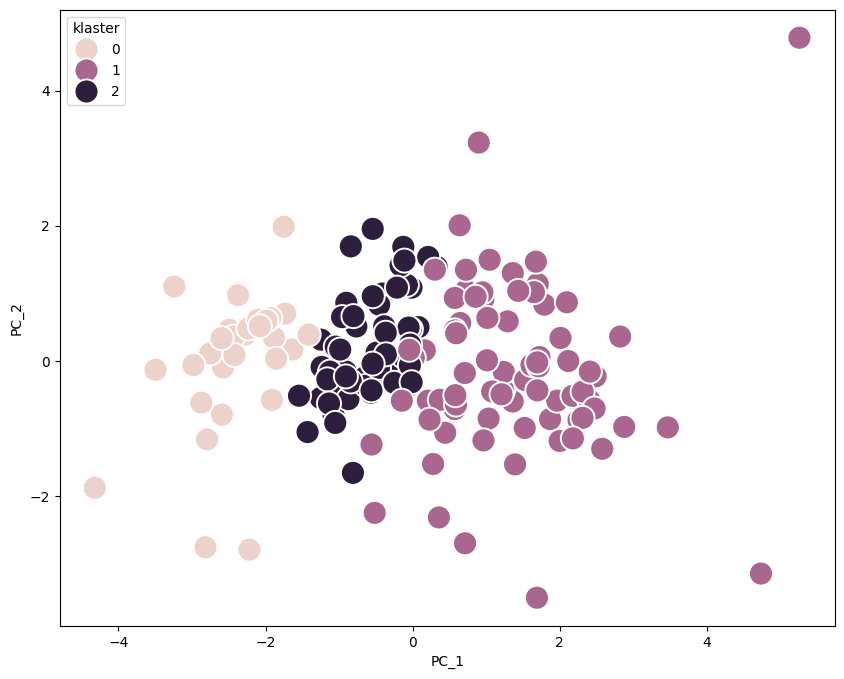

In [17]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
df_pca2 = pd.DataFrame(pca.fit_transform(df_gmm.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_gmm.index)

df_pca2 = pd.concat([df_pca2, df_gmm.klaster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca2, x = 'PC_1', y = 'PC_2', hue = 'klaster', s = 300, ax = ax)

In [18]:
# Gunakan metric silhouette score dan davies-bouldin index

from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette = silhouette_score(country_data1, df_gmm.klaster)
db_index = davies_bouldin_score(country_data1, df_gmm.klaster)

print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")

Silhouette Score: 0.20
Davies-Bouldin Index: 1.40


### 5. Fuzzy Clustering
Metode ini memungkinkan setiap data memiliki derajat keanggotaan dalam beberapa klaster. Tidak seperti metode analisis klaster pada umumnya (dikenal sebagai hard clustering), fuzzy clustering (dikenal sebagai soft clustering) memberikan bobot keanggotaan yang mencerminkan seberapa kuat data tersebut berada dalam setiap klaster. Metode ini lebih fleksibel dalam penanganan data yang ambigu atau data yang berada di perbatasan klaster dan tumpang tindih, tetapi prosesnya relatif lebih lambat karena kita harus menghitung keanggotaan setiap titik data di setiap klaster<br>
**Contoh**: Fuzzy C-Means (FCM)<br>
<img src=https://miro.medium.com/v2/resize:fit:1100/format:webp/1*bBYxRxPveZ8khii6Ge2T5Q.png alt="Fuzzy Clustering" width="500" height="250">



> ####  Fuzzy C-Means (FCM)
FCM menggunakan model pengelompokan fuzzy sehingga data dapat menjadi anggota dari semua kelas atau cluster terbentuk dengan derajat atau tingkat keanggotaan yang berbeda antara 0 hingga 1. Tingkat keberadaan data dalam suatu kelas
atau klaster ditentukan oleh derajat keanggotaannya.
<br><br>
Konsep dasar FCM, pertama kali adalah menentukan pusat klaster yang akan menandai lokasi rata-rata untuk tiap-tiap klasster. Pada kondisi awal pusat klaster ini masih belum akurat. Tiap-tiap data memiliki derajat keanggotaan untuk tiap-tiap cluster. Dengan cara memperbaiki pusat klaster dan nilai keanggotaan tiap-tiap data secara berulang, maka dapat dilihat bahwa pusat klaster akan menujui lokasi yang tepat.

In [19]:
! pip install fuzzy-c-means

  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.6.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


In [20]:
df_fcm = country_data1.copy()
df_fcm.head()

,child_mort,health,imports,inflation,life_expec,gdpp
country,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817


In [21]:
# Fuzzy C-Means
from fcmeans import FCM

fcm = FCM(n_clusters = 3)
fcm.fit(df_fcm.values)
df_fcm['klaster'] = fcm.predict(df_fcm.values)

# Sebaran klaster
print(df_fcm.klaster.value_counts())
df_fcm.head()

klaster
0    85
1    50
2    32
Name: count, dtype: int64


,child_mort,health,imports,inflation,life_expec,gdpp,klaster
country,,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180,1
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623,0
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376,0
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268,1
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817,0


In [22]:
# Dapatkan derajat keanggotaan untuk setiap titik data
membership_degrees = fcm.u

df_fcm2 = df_fcm.copy()
# Tambahkan kolom derajat keanggotaan ke DataFrame asli
for i in range(membership_degrees.shape[1]):
    df_fcm2[f'cluster_{i}_membership'] = membership_degrees[:, i]

df_fcm2.head(10)

,child_mort,health,imports,inflation,life_expec,gdpp,klaster,cluster_0_membership,cluster_1_membership,cluster_2_membership
country,,,,,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180,1,0.097983,0.856990,0.045027
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623,0,0.885202,0.046093,0.068705
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376,0,0.616915,0.226637,0.156449
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268,1,0.203049,0.699347,0.097604
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817,0,0.767496,0.072482,0.160022
Argentina,-0.591177,0.468966,-1.279787,1.244725,0.591474,-0.145791,0,0.442397,0.234124,0.323479
Armenia,-0.501643,-0.882089,-0.065883,-0.001123,0.309514,-0.533233,0,0.844181,0.091734,0.064084
Australia,-0.832423,0.699011,-1.076779,-0.628316,1.290735,2.130699,2,0.152427,0.078112,0.769461
Austria,-0.844858,1.527901,0.037693,-0.655549,1.121559,1.857082,2,0.087787,0.042297,0.869916


63.16622716747933 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

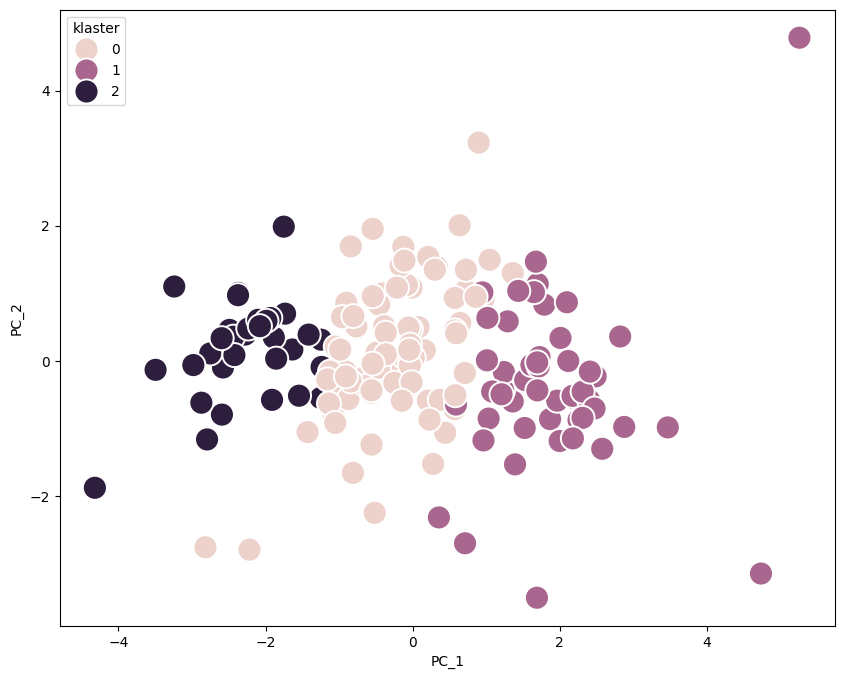

In [23]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
df_pca3 = pd.DataFrame(pca.fit_transform(df_fcm.iloc[:,:-1]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_fcm.index)

df_pca3 = pd.concat([df_pca3, df_fcm.klaster], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca3, x = 'PC_1', y = 'PC_2', hue = 'klaster', s = 300, ax = ax)

In [24]:
# Gunakan metric silhouette score dan davies-bouldin index

from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette = silhouette_score(country_data1, df_fcm.klaster)
db_index = davies_bouldin_score(country_data1, df_fcm.klaster)

print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")

Silhouette Score: 0.28
Davies-Bouldin Index: 1.27


# **B. Anomaly Detection**
Anomali adalah titik data (sampel) dalam kumpulan data yang berbeda dari keadaan normalnya dan bertentangan dengan perilaku data yang diharapkan. Anomali dalam data disebut juga outlier, noise, hal baru, dan pengecualian.
<br><br>
Deteksi anomali (anomaly detection) adalah teknik dalam machine learning yang digunakan untuk item, peristiwa, atau pengamatan langka yang mencurigakan dan tampak berbeda dari sebagian besar data. Data anomali ini sering kali menandakan informasi penting, seperti penipuan, kesalahan, kerusakan sistem, atau fenomena langka.
<br><br>
Metode deteksi anomali dikategorikan ke dalam pendekatan supervised dan unsupervised learning. Teknik deteksi anomali yang diawasi (supervised learning) memerlukan kumpulan data dengan kumpulan label “normal” dan “abnormal” yang lengkap agar algoritma klasifikasi dapat berfungsi. Sedangkan, metode deteksi anomali tanpa pengawasan (unsupervised learning) mendeteksi anomali dalam kumpulan data pengujian yang **tidak berlabel** hanya berdasarkan pada fitur pada data.
<br><br>
Definisi dari data **normal** dan **anomali** (abnormal) sangat bervariasi tergantung pada konteksnya. Berikut adalah beberapa contoh deteksi anomali dalam beberapa aktivitas:
1. Transaksi keuangan
  * Normal: Pembelian rutin dan pengeluaran keuangan yang konsisten oleh seseorang di Yogyakarta.
  * Anomali: Penarikan uang yang sangat besar dari Jakarta dari akun yang sama, menunjukkan potensi penipuan.
2. Lalu lintas jaringan dalam keamanan cyber
  * Normal: Komunikasi reguler, transfer data yang stabil, dan kepatuhan terhadap protokol.
  * Anomali: Peningkatan tiba-tiba dalam transfer data atau penggunaan protokol yang tidak dikenal yang mengindikasikan kemungkinan pelanggaran atau malware.
3. Pemantauan tanda vital pasien
  * Normal: Denyut jantung stabil dan tekanan darah yang konsisten
  * Anomali: Peningkatan tiba-tiba dalam denyut jantung dan penurunan tekanan darah, menunjukkan kemungkinan keadaan darurat atau kegagalan peralatan.



Beberapa teknik populer yang digunakan untuk deteksi anomali:
* Isolation Forest
* Local Outlier Factor
* K-Nearest Neighbor's
* One-Class Support Vector Machine
* Neural Networks and Autoencoders
<br><br>
Umumnya, analisis klasifikasi dengan label yang sangat tidak seimbang (misal 99.99% berbanding 0.01%) menggunakan pendekatan analisis deteksi anomali sebagai solusi yang menjanjikan, dimana label dengan proporsi sangat kecil digolongkan sebagai kejadian abnormal dan data dominasi sebagai kejadian normal

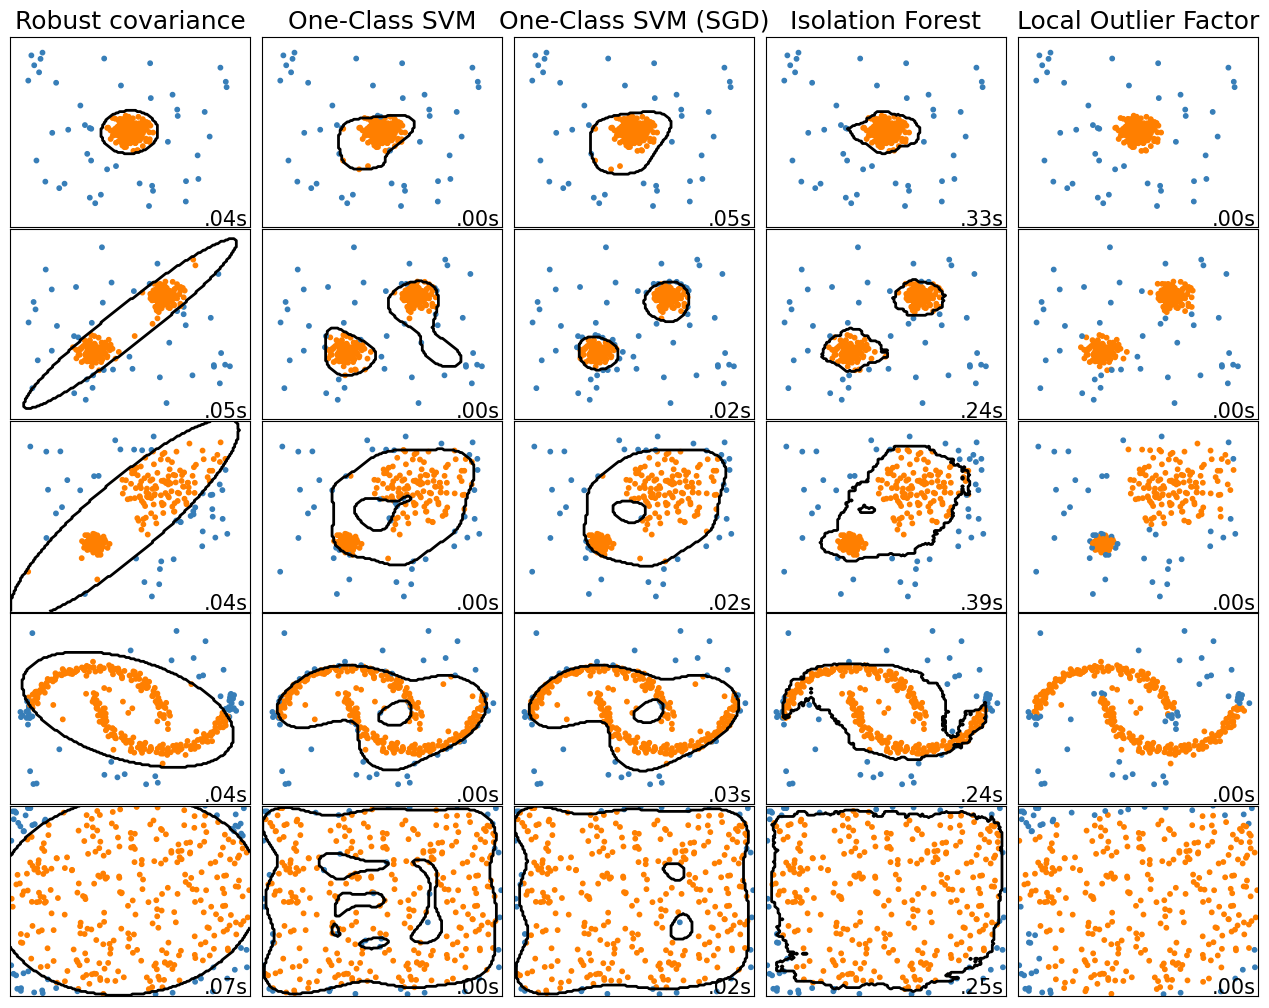

In [25]:
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs, make_moons
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM
anomaly_algorithms = [
    (
        "Robust covariance",
        EllipticEnvelope(contamination=outliers_fraction, random_state=42),
    ),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms)*2 + 3, 10))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

> ## **Isolation Forest**
Algoritma Isolation Forest mendeteksi anomali dengan membangun banyak pohon keputusan (decision trees) yang memisahkan data secara acak. Setiap pohon dibangun dengan memilih fitur dan nilai ambang batas secara acak untuk membagi data menjadi dua kelompok. Proses ini berlanjut hingga setiap data terisolasi di node daun (leaf node). Anomali (data abnormal), yang berbeda jauh dari data normal, akan terisolasi lebih cepat, membutuhkan lebih sedikit pembagian dibandingkan data normal. Dengan demikian, anomali dapat diidentifikasi karena mereka cenderung berada di level atas pohon, terpisah dalam lebih sedikit langkah daripada data normal.<br><br>
<img src=https://miro.medium.com/v2/resize:fit:1100/format:webp/1*y3wXEId0poYUIzCD3HBh4w.png alt="Isolation Forest" width="500" height="250">
<br><br>
Terakhir, 'skor anomali' diberikan ke setiap titik data berdasarkan kedalaman pohon yang diperlukan untuk sampai pada titik tersebut. Skor ini merupakan agregasi dari kedalaman yang diperoleh dari masing-masing iTrees. Skor anomali -1 diberikan untuk anomali dan 1 untuk titik normal berdasarkan parameter contamination (persentase anomali yang ada dalam data).
* scores:  indikasi seberapa jauh setiap titik data dari **normal** menurut model yang telah dilatih.
* anomaly_score: hasil prediksi biner yang dihasilkan oleh model Isolation Forest. Nilai ini menunjukkan apakah titik data dianggap normal (1) atau anomali (-1).








In [26]:
df_if = country_data1.copy()
df_if.head()

,child_mort,health,imports,inflation,life_expec,gdpp
country,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817


In [27]:
from sklearn.ensemble import IsolationForest

# parameter mirip dengan model random forest, dapat disesuaikan sesuai preferensi masing-masing
model_if = IsolationForest(n_estimators=100, max_samples='auto', contamination = float(0.05), random_state = 42) # 5% anomali
model_if.fit(df_if)

df_if['scores'] = model_if.decision_function(df_if)
df_if['anomaly_score'] = model_if.predict(df_if.drop('scores', axis = 1))

# # sebaran normal dan anomali
# print(df_if.anomaly_score.value_counts())
df_if.head(10)

,child_mort,health,imports,inflation,life_expec,gdpp,scores,anomaly_score
country,,,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180,0.121145,1
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623,0.186516,1
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376,0.140068,1
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268,0.050161,1
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817,0.178663,1
Argentina,-0.591177,0.468966,-1.279787,1.244725,0.591474,-0.145791,0.092104,1
Armenia,-0.501643,-0.882089,-0.065883,-0.001123,0.309514,-0.533233,0.180134,1
Australia,-0.832423,0.699011,-1.076779,-0.628316,1.290735,2.130699,0.098829,1
Austria,-0.844858,1.527901,0.037693,-0.655549,1.121559,1.857082,0.138125,1


63.16622716747933 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

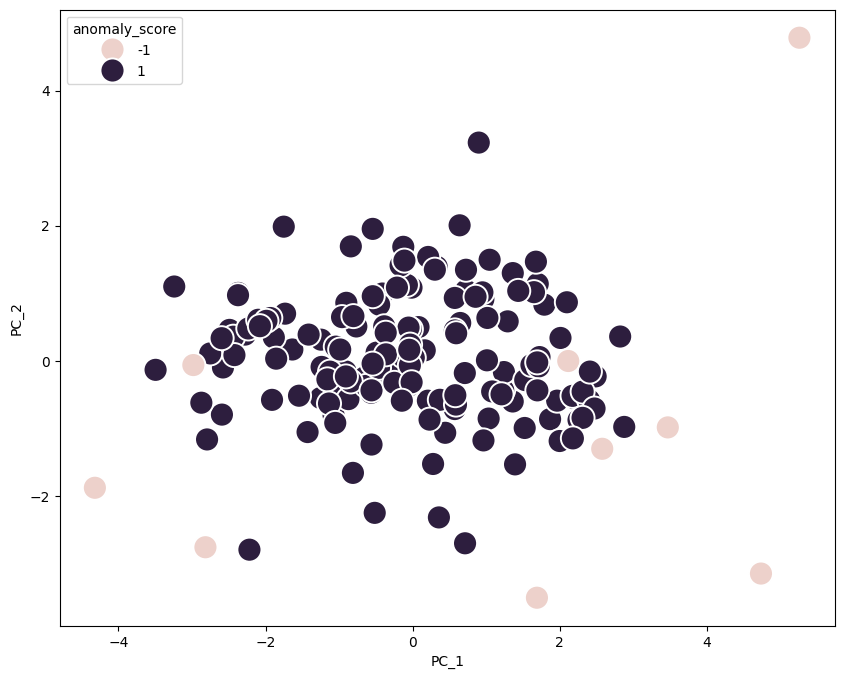

In [28]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
df_pca4 = pd.DataFrame(pca.fit_transform(df_if.iloc[:,:-2]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_if.index)

df_pca4 = pd.concat([df_pca4, df_if.anomaly_score], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca4, x = 'PC_1', y = 'PC_2', hue = 'anomaly_score', s = 300, ax = ax)

> ## **Local Outlier Factor**
Local Outlier Factor (LOF) adalah algoritma deteksi anomali yang mengidentifikasi outlier berdasarkan kepadatan lokal data. Ide utama di balik LOF adalah membandingkan kepadatan lokal titik data dengan kepadatan lokal dari tetangga terdekatnya atau mengukur deviasi lokal suatu titik data terhadap tetangganya.
<br><br>
Kepadatan dalam konteks Local Outlier Factor (LOF) adalah seberapa dekat titik data dengan titik-titik lain di sekitarnya. Secara sederhana, jika titik data memiliki banyak tetangga yang berdekatan, maka titik tersebut memiliki kepadatan tinggi. Namun, jika titik data jauh dari tetangganya, maka kepadatan titik tersebut rendah.
<br><br>
Algoritma ini mempertimbangkan jarak K-neighbors (tetangga) terdekat dari titik inti untuk memperkirakan kepadatan. Dengan membandingkan kepadatan lokal suatu objek dengan kepadatan lokal objek tetangganya, wilayah dengan kepadatan serupa dan titik-titik yang memiliki kepadatan jauh lebih rendah daripada wilayah tetangganya dapat diidentifikasi. Poin-poin ini dianggap outlier oleh algoritma. Beginilah cara anomali dideteksi dengan menggunakan algoritma LOF.
<br><br>
<img src=https://miro.medium.com/v2/resize:fit:828/format:webp/1*lEhrwi3nbKbT0TAijxJXtQ.png alt="LOF" width="450" height="350">
<br><br>
* scores: nilai LOF yang mengukur seberapa jauh setiap titik data dari **normalitas** dalam dataset. Nilai ini dihitung sebagai negative outlier factor, yang merupakan nilai negatif yang besar menunjukkan tingkat anomali yang tinggi. Semakin besar nilai negatifnya, semakin besar kemungkinan titik tersebut merupakan outlier.
* anomaly_score: hasil prediksi biner dari model LOF terhadap setiap titik data dalam dataset. Nilai ini menunjukkan apakah titik data dianggap normal (1) atau anomali (-1).






In [29]:
df_lof = country_data1.copy()
df_lof.head()

,child_mort,health,imports,inflation,life_expec,gdpp
country,,,,,,
Afghanistan,1.291532,0.279088,-0.082455,0.157336,-1.619092,-0.679180
Albania,-0.538949,-0.097016,0.070837,-0.312347,0.647866,-0.485623
Algeria,-0.272833,-0.966073,-0.641762,0.789274,0.670423,-0.465376
Angola,2.007808,-1.448071,-0.165315,1.387054,-1.179234,-0.516268
Antigua and Barbuda,-0.695634,-0.286894,0.497568,-0.601749,0.704258,-0.041817


In [30]:
from sklearn.neighbors import LocalOutlierFactor

model_lof = LocalOutlierFactor(n_neighbors = 20, contamination=0.1) # 10% anomali, n_neighbors dapat disesuaikan

df_lof['anomaly_score'] = model_lof.fit_predict(df_lof)
df_lof['scores'] = model_lof.negative_outlier_factor_

# sebaran normal dan anomali
print(df_lof.anomaly_score.value_counts())
df_lof.tail(10)

anomaly_score
 1    150
-1     17
Name: count, dtype: int64


,child_mort,health,imports,inflation,life_expec,gdpp,anomaly_score,scores
country,,,,,,,,
United Arab Emirates,-0.737914,-1.152299,0.692289,0.447686,0.670423,1.205874,-1,-1.505321
United Kingdom,-0.822475,1.031297,-0.666620,-0.589413,1.099002,1.419295,1,-1.045510
United States,-0.770246,4.047436,-1.288073,-0.622623,0.918548,1.939167,-1,-1.738823
Uruguay,-0.688173,0.560254,-0.890343,-0.272496,0.659145,-0.058234,1,-1.080060
Uzbekistan,-0.048997,-0.367227,-0.761910,0.827229,-0.198014,-0.633923,1,-1.030754
Vanuatu,-0.225578,-0.571711,0.240700,-0.489784,-0.852161,-0.546913,1,-1.118035
Venezuela,-0.526514,-0.695862,-1.213499,3.616865,0.546361,0.029323,-1,-1.922303
Vietnam,-0.372315,0.008877,1.380030,0.409732,0.286958,-0.637754,1,-1.209931
Yemen,0.448417,-0.597272,-0.517472,1.500916,-0.344633,-0.637754,1,-1.098973


63.16622716747933 %


<Axes: xlabel='PC_1', ylabel='PC_2'>

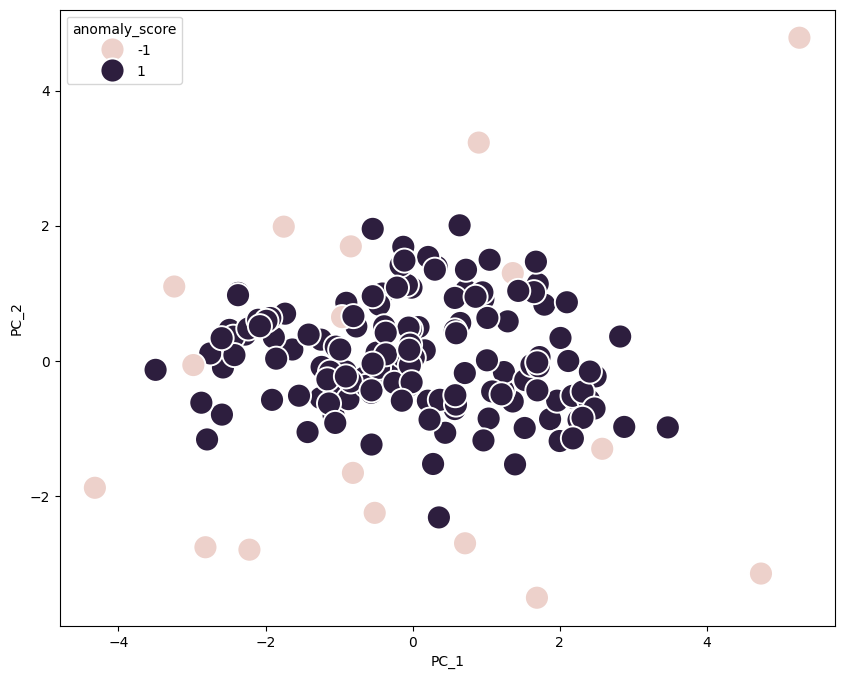

In [31]:
# Gunakan Dimensionality Reduction dengan PCA untuk mempermudah melakukan visualisasi

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
df_pca5 = pd.DataFrame(pca.fit_transform(df_lof.iloc[:,:-2]),
                      columns = ['PC_1', 'PC_2'],
                      index = df_lof.index)

df_pca5 = pd.concat([df_pca5, df_lof.anomaly_score], axis = 1)
# df_pca1.head()

print(np.sum(pca.explained_variance_ratio_)*100, "%") # 2 Dimensi dapat menjelaskan keseluruhan fitur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
sns.scatterplot(data = df_pca5, x = 'PC_1', y = 'PC_2', hue = 'anomaly_score', s = 300, ax = ax)

## Latihan Mandiri
Gunakan algoritma anomaly detection untuk kasus klasifikasi biner dengan kondisi ketidakseimbangan yang sangat tinggi.